# Getting best results per-shard using CANDLE HPO

In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from glob import glob

from keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Make all python scripts available in the path
import sys
sys.path.append('../')

In [32]:
import lrn_crv

In [33]:
filepath = Path(os.getcwd())
filepath

PosixPath('/vol/ml/apartin/projects/LearningCurves/notebooks')

In [34]:
hpodir1 = Path('/vol/ml/apartin/projects/LearningCurves/from_harry/lc_hpo_e700')
hpodir2 = Path('/vol/ml/apartin/projects/LearningCurves/from_harry/lc_hpo2_e700')

In [6]:
# --------------------------
#     UPF file
# --------------------------
# This file lists all the HPO runs (why id number is missing?)
# upf = pd.read_csv(basedir/'upf-lc-hpo.txt', header=None)
# upf.columns = ['id', 'epochs', 'dirpath', 'cv_folds', 'shards_arr', 'model_name', 'opt', 'lr', 'dr_rate', 'batch_size']

# Update df values
# upf['id'] = upf['id'].map(lambda x: x.split('"id": ')[-1].replace('"', ''))
# upf['epochs'] = upf['epochs'].map(lambda x: int(x.split('"epochs": ')[-1]))
# upf['dirpath'] = upf['dirpath'].map(lambda x: x.split('"dirpath": ')[-1].replace('"', ''))
# upf['cv_folds'] = upf['cv_folds'].map(lambda x: int(x.split('"cv_folds": ')[-1]))
# upf['shards_arr'] = upf['shards_arr'].map(lambda x: int(x.split('"shards_arr": ')[-1].replace('[', '').replace(']', '')) )
# upf['model_name'] = upf['model_name'].map(lambda x: x.split('"model_name": ')[-1].replace('"', ''))
# upf['opt'] = upf['opt'].map(lambda x: x.split('"opt": ')[-1].replace('"', ''))
# upf['lr'] = upf['lr'].map(lambda x: float(x.split('"lr": ')[-1]))
# upf['dr_rate'] = upf['dr_rate'].map(lambda x: float(x.split('"dr_rate": ')[-1]))
# upf['batch_size'] = upf['batch_size'].map(lambda x: x.split('"batch_size": ')[-1].rstrip('\}'))

# upf[:5]

# Utils

In [7]:
def df_from_upf_run(hpo_dir):
    """ Aggregate results from all HPO runs into a dataframe. """
    hp = []
    all_runs = sorted(glob(str(hpo_dir/'run'/'id_*'))) # each run starts with "id_"
    print('Total runs {}'.format( len(all_runs) ))
    
    for i, r in enumerate(all_runs):
        r = glob(str(Path(r)/'output'/'*'))[0]

        # Load args from the current run into dict
        with open(Path(r)/'args.txt', 'r') as f:
            args = {}
            for l in f:
                k, v = l.rstrip('\n').split(': ')
                args[k] = v

        # Load scores, parse, and add
        if (Path(r)/'lrn_crv_scores.csv').exists():
            # Note! lrn_crv_scores.csv doesn't exist if it's timed out
            scr = pd.read_csv(Path(r)/'lrn_crv_scores.csv')
            tr_size = int(args['shards_arr'].replace('[','').replace(']',''))
            aa = scr.loc[(scr['tr_size']==tr_size) & (scr['tr_set']==False), ['metric', 'fold1']].reset_index(drop=True)  # Note! Gets only the first fold!
            # aa = scr.loc[(scr['tr_size']==tr_size) & (scr['set']=='te'), ['metric', 'fold1']].reset_index(drop=True)
            d = {aa.loc[i, 'metric']: aa.loc[i, 'fold1'] for i in range(aa.shape[0])}    

        # Add epoch number of early stop
        tr_dir = Path(glob(str(Path(r)/(f'cv*_sz'+str(tr_size))))[0])
        if tr_dir.exists():
            if (tr_dir/'krs_history.csv').exists():
                h = pd.read_csv(tr_dir/'krs_history.csv')
                d['epoch_stop'] = h['epoch'].max()

        # Update dict
        args.update(d)

        # Agg info from all runs
        hp.append(args)

    hp = pd.DataFrame(hp)
    print('hp.shape', hp.shape)

    # Update values
    hp['shards_arr'] = hp['shards_arr'].map(lambda x: int(x.replace('[', '').replace(']', '')))
    
    # Cast columns to specific types
    hp = hp.astype({'shards_arr': int, 'batch_size': int, 'lr': float, 'opt': str, 'dr_rate': float,
                    'mean_absolute_error': float, 'mean_squared_error': float, 'median_absolute_error': float, 'r2': float})
    
    return hp

In [8]:
def top_n_runs(df, shard_size=None, n=10, sort_by_metric='r2', plot=False):
    """ Return top runs based on sort_by_metric. """
    if shard_size is not None:
        df = df[df['shards_arr']==shard_size].reset_index(drop=True)
    if sort_by_metric == 'r2':
        df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
    else:
        df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
    if plot: display(df.transpose())
    return df.reset_index(drop=True)

# Load results from runs

In [9]:
hp1 = df_from_upf_run(hpo_dir=hpodir1)
hp2 = df_from_upf_run(hpo_dir=hpodir2)

Total runs 384
hp.shape (384, 38)
Total runs 768
hp.shape (768, 38)


In [10]:
hp = pd.concat([hp2, hp1], axis=0)
print(hp.columns.values)

# Subset of columns
col_subset = ['shards_arr',
              'batch_size', 'lr', 'opt', 'dr_rate',  # HPs
              # 'batchnorm', 'clr_mode', 'cv_method', 'scaler', 'epoch_stop',  # potential DL HPs
              # 'n_trees',  # potential LGBM HPs
              # 'cell_fea', 'drug_fea', 'target_name',  # features and response
              # 'epochs', 'framework', 'model_name', 'cv_folds',  # ML settings
              # 'run_id', 'shard_step_scale', # Other
              'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', # scores
             ]

hp = hp[col_subset]
display(hp.head())

['batch_size' 'batchnorm' 'cell_fea' 'clr_base_lr' 'clr_gamma'
 'clr_max_lr' 'clr_mode' 'cv_folds' 'cv_folds_arr' 'cv_method' 'dirpath'
 'dr_rate' 'drug_fea' 'epoch_stop' 'epochs' 'experiment_id' 'framework'
 'id' 'instance_directory' 'lr' 'max_shard' 'mean_absolute_error'
 'mean_squared_error' 'median_absolute_error' 'min_shard' 'model_name'
 'n_jobs' 'n_shards' 'n_trees' 'opt' 'r2' 'run_id' 'save' 'scaler'
 'shard_step_scale' 'shards_arr' 'target_name' 'timeout']


,shards_arr,batch_size,lr,opt,dr_rate,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,1024,32,0.00001,adam,0.0,0.144673,0.041725,0.110560,-0.971707
1,1024,64,0.00001,adam,0.0,0.192789,0.072768,0.148873,-2.438680
2,1024,128,0.00001,adam,0.0,0.230673,0.097832,0.182238,-3.623052
3,1024,256,0.00001,adam,0.0,0.229750,0.106603,0.173592,-4.037513
4,1024,32,0.00001,adam,0.1,0.231362,0.067947,0.232960,-2.210832


In [11]:
# hp.groupby('shards_arr')['batch_size'].value_counts()

In [12]:
# hp.batch_size.value_counts()
# hp.opt.value_counts()
# hp.shards_arr.value_counts()
# hp.lr.value_counts()
# hp.sort_values('mean_absolute_error')

In [13]:
a = hp.groupby('shards_arr').agg({'batch_size': 'unique', 'dr_rate': 'unique', 'opt': 'unique', 'lr': 'unique',
                                  'mean_absolute_error': 'min', 'mean_squared_error': 'min', 'r2': 'max'}).reset_index()
a

,shards_arr,batch_size,dr_rate,opt,lr,mean_absolute_error,mean_squared_error,r2
0,1024,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.081609,0.012222,0.422446
1,2048,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.0001, 1e-05, 0.001, 0.01]",0.076894,0.011584,0.452597
2,4096,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.0001, 0.001, 1e-05, 0.01]",0.069809,0.009335,0.558893
3,8192,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.0001, 0.001, 0.01, 1e-05]",0.062945,0.007838,0.629628
4,16384,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.0001, 0.001, 0.01, 1e-05]",0.058083,0.006778,0.679727
5,32768,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.0001, 0.001, 0.01, 1e-05]",0.052608,0.006032,0.714942
6,65536,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.001, 0.01, 0.0001]",0.049140,0.005496,0.740268
7,131072,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.001, 1e-05, 0.01, 0.0001]",0.047997,0.005068,0.760502
8,262144,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[0.001, 0.01, 1e-05, 0.0001]",0.045759,0.004626,0.781399


# Plot all runs per metric

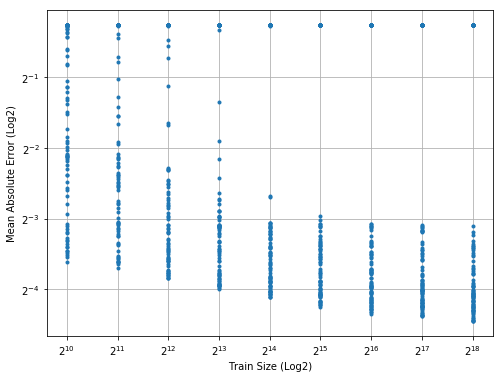

In [57]:
met = 'mean_absolute_error'
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(hp['shards_arr'], hp[met], '.'); plt.grid(True); plt.xlabel('Train Size (Log2)'); plt.ylabel(lrn_crv.capitalize_metric(met) + ' (Log2)');
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

# Every-shard HPO
Extract the best performance score for every shard (for each metric)

In [124]:
# https://datascience.stackexchange.com/questions/26308/after-grouping-to-minimum-value-in-pandas-how-to-display-the-matching-row-resul
hp_by_mae = hp.sort_values('mean_absolute_error', ascending=True).drop_duplicates(['shards_arr']).sort_values('shards_arr').reset_index(drop=True)
# hp_by_mse = hp.sort_values('mean_squared_error', ascending=True).drop_duplicates(['shards_arr']).sort_values('shards_arr').reset_index(drop=True)
# hp_by_r2  = hp.sort_values('r2', ascending=False).drop_duplicates(['shards_arr']).sort_values('shards_arr').reset_index(drop=True)

In [125]:
rs1 = hp_by_mae
display(rs1)

,shards_arr,batch_size,lr,opt,dr_rate,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,1024,32,0.0001,adam,0.1,0.081609,0.012222,0.061056,0.422446
1,2048,32,0.0001,adam,0.2,0.076894,0.011601,0.053368,0.451814
2,4096,32,0.0001,adam,0.2,0.069809,0.009557,0.047999,0.548378
3,8192,32,0.0001,adam,0.1,0.062945,0.007838,0.044713,0.629628
4,16384,128,0.0001,adam,0.1,0.058083,0.006778,0.040076,0.679727
5,32768,32,0.0001,adam,0.0,0.052608,0.006032,0.034771,0.714942
6,65536,32,0.0001,adam,0.0,0.049140,0.005524,0.031449,0.738972
7,131072,128,0.0001,adam,0.0,0.047997,0.005280,0.030599,0.750503
8,262144,32,0.0001,adam,0.0,0.045759,0.004804,0.029237,0.772967


In [126]:
# _, ax = plt.subplots(figsize=(8,6))
# ax.plot(rs['shards_arr'], rs['mean_absolute_error'], '.'); plt.title('Every-shard HPO')
# plt.ylabel('Mean Absolute Error'); plt.xlabel('Train Size'); plt.grid(True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe8537f2358>,
 {'alpha': 0.2518561423765148,
  'beta': -0.2222013127295832,
  'gamma': 0.02902433647464288})

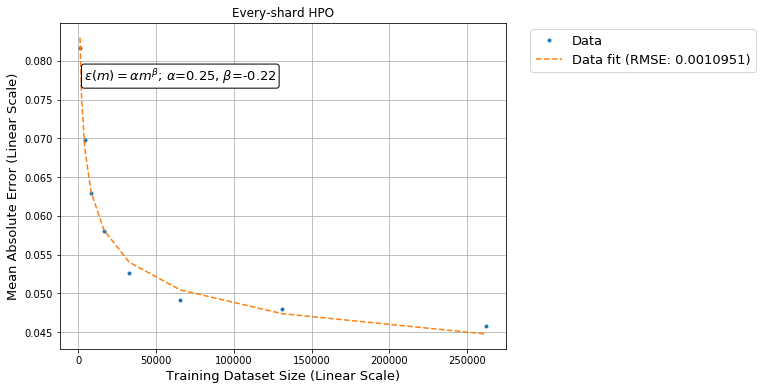

In [138]:
lrn_crv.plot_lrn_crv_power_law(x=rs['shards_arr'], y=rs[met],
                               plot_fit=True, metric_name=met,
                               # xtick_scale='log2', ytick_scale='log2',
                               xtick_scale='linear', ytick_scale='linear', 
                               title='Every-shard HPO', label='Data', ax=None, figsize=(8,6))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe8539b9ac8>,
 {'alpha': 0.22112937390669551,
  'beta': -0.18606163484297739,
  'gamma': 0.021899924533575033})

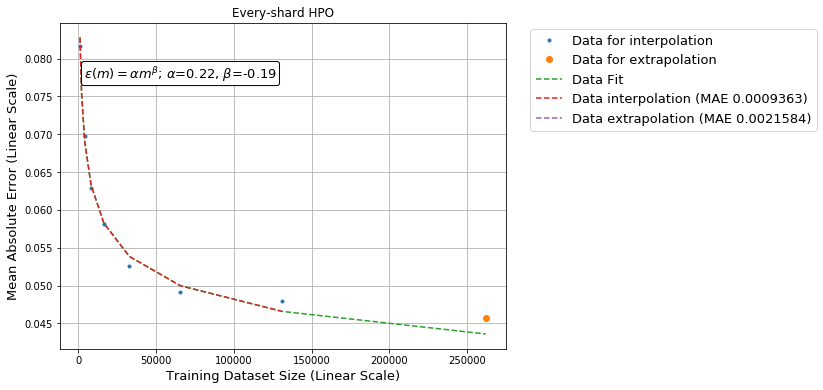

In [132]:
lrn_crv.lrn_crv_power_law_extrapolate(x=rs['shards_arr'], y=rs[met],
                                      m0 = 8,
                                      plot_fit=True, metric_name=met,
                                      # xtick_scale='log2', ytick_scale='log2',
                                      xtick_scale='linear', ytick_scale='linear',
                                      title='Every-shard HPO', label='Data', ax=None, figsize=(8,6))

# Largest-shard HPO
Extract the best performance score for the largest shard (for each metric)

In [139]:
rs2 = top_n_runs(hp, shard_size=262144, n=1, sort_by_metric='mean_absolute_error', plot=False)
display(rs2)

,shards_arr,batch_size,lr,opt,dr_rate,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,262144,32,0.0001,adam,0.0,0.045759,0.004804,0.029237,0.772967


In [140]:
idx = (hp['opt']==rs2['opt'][0]) & (hp['lr']==rs2['lr'][0]) & (hp['dr_rate']==rs2['dr_rate'][0]) & (hp['batch_size']==rs2['batch_size'][0])
df = hp[ idx ].sort_values('shards_arr').reset_index(drop=True)
# display(df)

In [141]:
# _, ax = plt.subplots(figsize=(8,6))
# ax.plot(rs['shards_arr'], rs['mean_absolute_error'], '--.'); plt.title('Largest-shard HPO')
# plt.ylabel('Mean Absolute Error'); plt.xlabel('Train Size'); plt.grid(True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe85377b4e0>,
 {'alpha': 1.7897165758799793,
  'beta': -0.49732670014789476,
  'gamma': 0.04282902986831782})

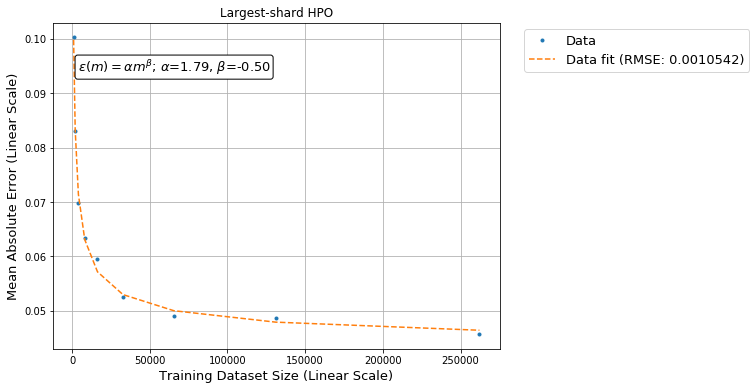

In [142]:
lrn_crv.plot_lrn_crv_power_law(x=df['shards_arr'], y=df[met],
                               plot_fit=True, metric_name=met,
                               # xtick_scale='log2', ytick_scale='log2', 
                               xtick_scale='linear', ytick_scale='linear',
                               title='Largest-shard HPO', label='Data', ax=None, figsize=(8,6))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe85370d128>,
 {'alpha': 1.9933496377620377,
  'beta': -0.5148353296330849,
  'gamma': 0.04372877586022137})

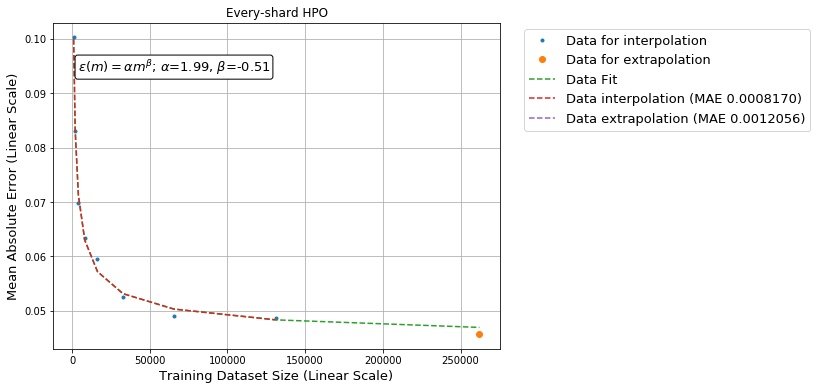

In [143]:
lrn_crv.lrn_crv_power_law_extrapolate(x=df['shards_arr'], y=df['mean_absolute_error'],
                                      m0 = 8,
                                      plot_fit=True, metric_name='mean_absolute_error',
                                      # xtick_scale='log2', ytick_scale='log2',
                                      xtick_scale='linear', ytick_scale='linear',
                                      title='Every-shard HPO', label='Data', ax=None, figsize=(8,6))

# Previous HP Settings (not optimized)

In [189]:
idx = (hp['opt']=='sgd') & (hp['lr']==0.0001) & (hp['dr_rate']==0.2) & (hp['batch_size']==32)
df = hp[ idx ].sort_values('shards_arr').reset_index(drop=True)
display(df)

,shards_arr,batch_size,lr,opt,dr_rate,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,1024,32,0.0001,sgd,0.2,0.116332,0.019930,0.112465,0.058226
1,2048,32,0.0001,sgd,0.2,0.112946,0.019277,0.107589,0.089070
2,4096,32,0.0001,sgd,0.2,0.108167,0.017813,0.100739,0.158235
3,8192,32,0.0001,sgd,0.2,0.099160,0.015339,0.089884,0.275152
4,16384,32,0.0001,sgd,0.2,0.094073,0.014291,0.080651,0.324663
5,32768,32,0.0001,sgd,0.2,0.086323,0.012527,0.070321,0.408034
6,65536,32,0.0001,sgd,0.2,0.075593,0.010236,0.059036,0.516294
7,131072,32,0.0001,sgd,0.2,0.071975,0.008895,0.058246,0.579660
8,262144,32,0.0001,sgd,0.2,0.065576,0.007533,0.051647,0.644039


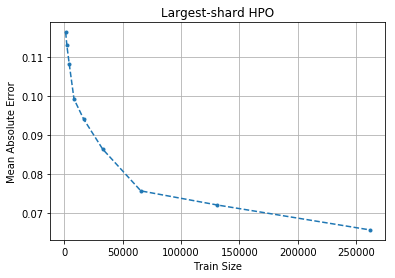

In [190]:
plt.plot(df['shards_arr'], df['mean_absolute_error'], '--.'); plt.title('Largest-shard HPO')
plt.ylabel('Mean Absolute Error'); plt.xlabel('Train Size'); plt.grid(True)

In [191]:
ax, pwr_law_prms = lrn_crv.plot_lrn_crv_power_law(x=df['shards_arr'], y=df['mean_absolute_error'],
                                                  plot_fit=True, metric_name='mean_absolute_error',
                                                  xtick_scale='log2', ytick_scale='log2', title='Largest-shard HPO', label='Data', ax=None)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [42]:
# d1 = hp[hp['shards_arr']==65536].reset_index(drop=True)
d1 = hp.reset_index(drop=True)
print(d1.shape)
d1 = d1[d1['r2']>0.73]
print(d1.shape)

(384, 24)
(46, 24)


In [43]:
d1.groupby('shards_arr').agg({'batch_size': 'unique', 'dr_rate': 'unique', 'opt': 'unique', 'lr': 'unique',
                              'mean_absolute_error': 'min', 'mean_squared_error': 'min', 'r2': 'max'}).reset_index()
# d1.groupby('shards_arr')['batch_size'].value_counts()

,shards_arr,batch_size,dr_rate,opt,lr,mean_absolute_error,mean_squared_error,r2
0,65536,"[32, 64, 128, 256]","[0.1, 0, 0.2]","[adam, sgd]","[1e-05, 0.01, 0.0001]",0.049140,0.005496,0.740268
1,131072,"[32, 64, 128, 256]","[0, 0.1, 0.2]","[adam, sgd]","[1e-05, 0.001, 0.01, 0.0001]",0.047997,0.005068,0.760502
2,262144,"[32, 64, 256, 128]","[0, 0.1, 0.2]","[adam, sgd]","[1e-05, 0.001, 0.01, 0.0001]",0.045759,0.004626,0.781399


In [53]:
df = top_runs(hp, shard_size=65536, n=1)
display(df)

,batch_size,lr,opt,dr_rate,batchnorm,cell_fea,clr_mode,cv_folds,cv_method,drug_fea,...,run_id,scaler,shard_step_scale,shards_arr,target_name,epoch_stop,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,128,0.0001,adam,0.1,False,['GE'],None,1,simple,['DD'],...,id_54,stnd,log2,65536,AUC,122,0.051723,0.005496,0.03616,0.740268


In [54]:
df = top_n_runs(hp, shard_size=131072, n=1)
display(df)

,batch_size,lr,opt,dr_rate,batchnorm,cell_fea,clr_mode,cv_folds,cv_method,drug_fea,...,run_id,scaler,shard_step_scale,shards_arr,target_name,epoch_stop,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,32,0.0001,adam,0.1,False,['GE'],None,1,simple,['DD'],...,id_68,stnd,log2,131072,AUC,107,0.048234,0.005068,0.031422,0.760502


In [55]:
df = top_n_runs(hp, shard_size=262144, n=1)
display(df)

,batch_size,lr,opt,dr_rate,batchnorm,cell_fea,clr_mode,cv_folds,cv_method,drug_fea,...,run_id,scaler,shard_step_scale,shards_arr,target_name,epoch_stop,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,64,0.0001,adam,0.1,False,['GE'],None,1,simple,['DD'],...,id_85,stnd,log2,262144,AUC,91,0.045795,0.004626,0.029842,0.781399
